# Lindblad Resonance Torques in Kerr Spacetime

This notebook demonstrates how to compute the **gravitational torques** exerted by a
circularly-orbiting perturber (e.g. a stellar-mass compact object) on a thin accretion disk
around a Kerr black hole via **Lindblad resonances**. It is based on the formalism developed by Hirata in and applied in Duque et al. 

We walk through three levels of computation:

1. **Mode-by-mode normalised torque** $\hat{T}_m$ — the dimensionless torque strength for a single azimuthal number $m$ and resonance type (inner / outer Lindblad).
2. **Physical torque per mode** — dressing $\hat{T}_m$ with the disk surface density $\Sigma$ at the resonance location.
3. **Total torque with soft cutoff** — summing over $m$ with a physically-motivated cutoff controlled by the disk aspect ratio $h = H/r$.

---

### Physical picture

| Quantity | Symbol | Description |
|---|---|---|
| Black hole spin | $a$ | Dimensionless Kerr parameter $0 \le a < 1$ |
| Perturber radius | $r_p$ | Circular equatorial orbit of the small body |
| Resonance radius | $r_{\rm res}$ | Where $m(\Omega - \Omega_p) = \pm \kappa$ |
| Inner Lindblad (ILR) | sign = +1 | $r_{\rm res} < r_p$ |
| Outer Lindblad (OLR) | sign = -1 | $r_{\rm res} > r_p$ |
| Disk model | Novikov-Thorne | Parametrised by viscosity $\alpha$ and accretion rate $\dot{m}$ |

---
## 0. Imports

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# ---- Black hole perturbation theory (Teukolsky equation) ----
from pybhpt.geo import KerrGeodesic
from pybhpt.swsh import swsh_eigenvalue
from pybhpt.radial import RadialTeukolsky
from pybhpt.teuk import TeukolskyMode

# ---- Laplace coefficients (optional Newtonian comparison) ----
from pylaplace import LaplaceCoefficient
laplace = LaplaceCoefficient(method='Brute')

---
## 1. Kerr Geometry: Circular Equatorial Orbits

All quantities are evaluated on the **equatorial plane** ($\theta = \pi/2$)
in Boyer-Lindquist coordinates with $G = c = M_{\rm BH} = 1$.

### 1.1 Metric functions

In [2]:
def metric_Delta(r, a):
    """Kerr horizon function: Delta = r^2 - 2r + a^2."""
    return r**2 - 2.0*r + a**2

def metric_Sigma_eq(r, a):
    """Sigma on the equatorial plane: r^2 (since cos(pi/2) = 0)."""
    return r**2

# ---- Contravariant (inverse) metric components on equatorial plane ----

def g_up_rr(r, a):
    """g^{rr} = Delta / Sigma."""
    return metric_Delta(r, a) / metric_Sigma_eq(r, a)

def g_up_tt(r, a):
    """g^{tt} on equatorial plane."""
    D, S = metric_Delta(r, a), metric_Sigma_eq(r, a)
    return -((r**2 + a**2)**2 - D*a**2) / (S*D)

def g_up_phiphi(r, a):
    """g^{phi phi} on equatorial plane (sin^2(pi/2) = 1)."""
    D, S = metric_Delta(r, a), metric_Sigma_eq(r, a)
    return (D - a**2) / (D*S)

def g_up_tphi(r, a):
    """g^{t phi} on equatorial plane."""
    D, S = metric_Delta(r, a), metric_Sigma_eq(r, a)
    return -2.0*a*r / (S*D)

### 1.2 Orbital frequencies and ISCO

In [3]:
def orbital_frequency(r, a):
    """Azimuthal frequency Omega_phi for a prograde circular equatorial orbit."""
    return 1.0 / (r**1.5 + a)

def d_orbital_frequency_dr(r, a):
    """d(Omega_phi)/dr."""
    return -1.5 * r**0.5 / (r**1.5 + a)**2

def epicyclic_frequency(r, a):
    """Radial epicyclic frequency kappa(r) for circular equatorial orbits."""
    return orbital_frequency(r, a) * np.sqrt(
        1.0 - 6.0/r + 8.0*a/r**1.5 - 3.0*a**2/r**2)

def isco_radius(a, prograde=True):
    """Innermost stable circular orbit (ISCO) radius in Kerr."""
    Z1 = 1.0 + (1.0 - a**2)**(1./3) * ((1.0+a)**(1./3) + (1.0-a)**(1./3))
    Z2 = np.sqrt(3.0*a**2 + Z1**2)
    s = -1.0 if prograde else 1.0
    return 3.0 + Z2 + s*np.sqrt((3.0 - Z1)*(3.0 + Z1 + 2.0*Z2))

### 1.3 Specific energy, angular momentum, four-velocity

In [4]:
def specific_angular_momentum(r, a):
    """L_z for a prograde circular equatorial orbit."""
    return (r**2 - 2.0*a*r**0.5 + a**2) / (r**0.75 * np.sqrt(r**1.5 - 3.0*r**0.5 + 2.0*a))

def specific_energy(r, a):
    """E for a prograde circular equatorial orbit."""
    return (r**1.5 - 2.0*r**0.5 + a) / (r**0.75 * np.sqrt(r**1.5 - 3.0*r**0.5 + 2.0*a))

def u_t(r, a):
    """Time component of the 4-velocity:  u^t = -g^{tt} E + g^{t phi} L_z."""
    return -g_up_tt(r, a)*specific_energy(r, a) + specific_angular_momentum(r, a)*g_up_tphi(r, a)

def d_specific_angular_momentum_dr(r, a):
    """dL_z/dr (closed-form)."""
    num = (3.0*a**2 - 8.0*a*np.sqrt(r) - (-6.0+r)*r) * (a + r**1.5)
    den = 2.0 * (2.0*a + (-3.0+r)*np.sqrt(r))**1.5 * r**(7./4)
    return -num / den

### 1.4 Epicyclic impedance

The **epicyclic impedance** $Z_{\rm epi} = \sqrt{C_{020}/C_{002}}$ characterises the disk's
local response to perturbations.  The WKB coefficients are:

$$
C_{002} = \frac{g^{rr}}{u^t}, \qquad
C_{020} = -\frac{d\Omega}{dr}\frac{dL_z}{dr}
          + \frac{(g^{t\phi})^2 - g^{tt}g^{\phi\phi}}{(u^t)^3}
            \left(\frac{dL_z}{dr}\right)^2.
$$

In [5]:
def coeff_C002(r, a):
    """Radial WKB coefficient C_{002} = g^{rr} / u^t."""
    return g_up_rr(r, a) / u_t(r, a)

def coeff_C020(r, a):
    """Angular WKB coefficient C_{020}."""
    dL = d_specific_angular_momentum_dr(r, a)
    cross = g_up_tphi(r, a)**2 - g_up_tt(r, a)*g_up_phiphi(r, a)
    return -d_orbital_frequency_dr(r, a)*dL + cross/u_t(r, a)**3 * dL**2

def epicyclic_impedance(r, a):
    """Z_epi = sqrt(C020 / C002) -- impedance at a resonance location."""
    return np.sqrt(coeff_C020(r, a) / coeff_C002(r, a))

### Quick sanity check

In [6]:
a_test, r_test = 0.8, 10.0
print(f"Spin a = {a_test}")
print(f"ISCO   = {isco_radius(a_test):.4f} M")
print(f"Omega(r={r_test})  = {orbital_frequency(r_test, a_test):.6f}")
print(f"kappa(r={r_test})  = {epicyclic_frequency(r_test, a_test):.6f}")
print(f"Z_epi(r={r_test})  = {epicyclic_impedance(r_test, a_test):.6f}")

Spin a = 0.8
ISCO   = 2.9066 M
Omega(r=10.0)  = 0.030843
kappa(r=10.0)  = 0.023553
Z_epi(r=10.0)  = 0.034566


---
## 2. Resonance Locations: The Detuning Function

A Lindblad resonance of order $m$ sits at $r_{\rm res}$ where

$$
D_m^{\pm}(r) = m\bigl[\Omega(r) - \Omega(r_p)\bigr] \mp \kappa(r) = 0.
$$

- **ILR** (sign = +1): resonance inside $r_p$
- **OLR** (sign = -1): resonance outside $r_p$

In [7]:
def detuning_function(sign, m, r_perturber, a, r):
    """
    Resonant detuning function D_m(r).  Zeros = resonance locations.
    
    Parameters
    ----------
    sign        : +1 (ILR) or -1 (OLR)
    m           : azimuthal mode number (integer >= 2)
    r_perturber : orbital radius of the perturbing body
    a           : Kerr spin parameter
    r           : radius at which to evaluate
    """
    return m*(orbital_frequency(r, a) - orbital_frequency(r_perturber, a)) \
           - sign*epicyclic_frequency(r, a)


def find_resonance_radius(sign, m, r_perturber, a):
    """Solve D_m(r_res) = 0.  Initial guess: slightly inside/outside r_p."""
    r0 = 0.9*r_perturber if sign > 0 else 1.1*r_perturber
    return fsolve(lambda r: detuning_function(sign, m, r_perturber, a, r), r0)[0]


def detuning_derivative(sign, m, r_perturber, a, r):
    """dD_m/dr at the resonance -- appears in the torque denominator."""
    def d_epicyclic_dr(r, a):
        Om  = orbital_frequency(r, a)
        dOm = d_orbital_frequency_dr(r, a)
        inner = 1.0 - 6.0/r + 8.0*a/r**1.5 - 3.0*a**2/r**2
        sqrt_inner = np.sqrt(inner)
        d_sqrt = (6.0/r**2 - 12.0*a/r**2.5 + 6.0*a**2/r**3) / (2.0*sqrt_inner)
        return dOm*sqrt_inner + Om*d_sqrt
    return m*d_orbital_frequency_dr(r, a) - sign*d_epicyclic_dr(r, a)

### Example: resonance locations (cf. paper Fig. 2)

In [8]:
a_val, r_p = 0.0, 10.0

print(f"Spin a = {a_val},  Perturber r_p = {r_p} M,  ISCO = {isco_radius(a_val):.4f} M\n")
print(f"{'m':>3}  {'r_ILR':>12}  {'r_OLR':>12}")
print('-'*32)
for m in range(2, 8):
    ri = find_resonance_radius(+1, m, r_p, a_val)
    ro = find_resonance_radius(-1, m, r_p, a_val)
    print(f"{m:3d}  {ri:12.5f}  {ro:12.5f}")

Spin a = 0.0,  Perturber r_p = 10.0 M,  ISCO = 6.0000 M

  m         r_ILR         r_OLR
--------------------------------
  2       8.19147      12.25866
  3       8.71725      11.48187
  4       9.01167      11.10001
  5       9.19752      10.87383
  6       9.32500      10.72451
  7       9.41771      10.61864


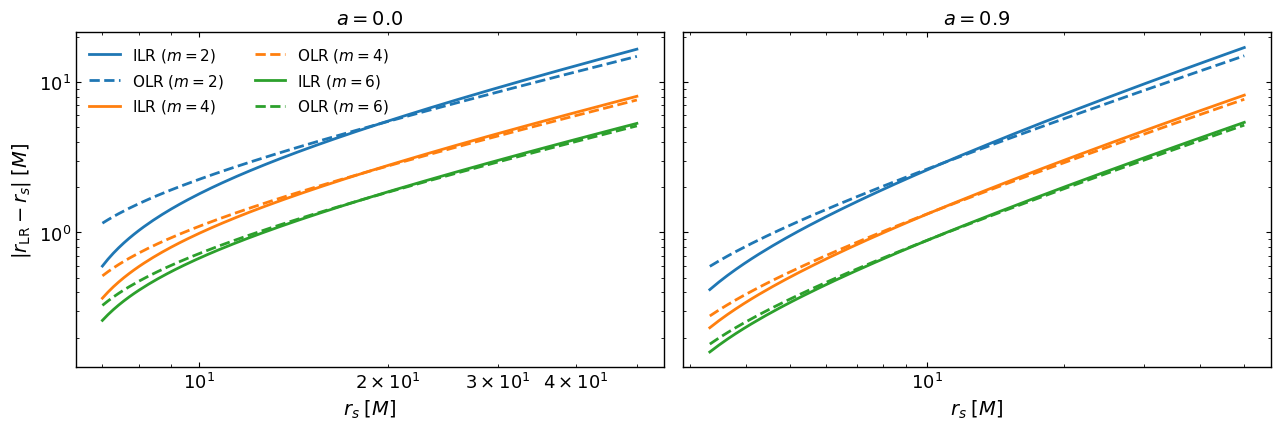

In [9]:
# ---- Resonance distance from the secondary (cf. paper Fig. 2) ----
# Plot |r_LR - r_s| vs r_s for m = 2, 4, 6  —  two panels: a=0 and a=0.9

plt.rcParams.update({
    'font.size': 13, 'axes.labelsize': 14,
    'legend.fontsize': 11, 'xtick.direction': 'in',
    'ytick.direction': 'in', 'xtick.top': True,
    'ytick.right': True, 'axes.linewidth': 1.0,
})

m_values_plot = [2, 4, 6]
colors = ['C0', 'C1', 'C2']
spin_values = [0.0, 0.9]

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharey=True)

for ax, a_spin in zip(axes, spin_values):
    r_isco_loc = isco_radius(a_spin)
    r_s_arr = np.linspace(r_isco_loc + 1.0, 50, 300)

    for m_show, col in zip(m_values_plot, colors):
        dist_ilr = np.array([find_resonance_radius(+1, m_show, rs, a_spin) - rs
                              for rs in r_s_arr])
        dist_olr = np.array([find_resonance_radius(-1, m_show, rs, a_spin) - rs
                              for rs in r_s_arr])
        ax.plot(r_s_arr, np.abs(dist_ilr), color=col, lw=2, ls='-',
                label=rf'ILR ($m={m_show}$)')
        ax.plot(r_s_arr, np.abs(dist_olr), color=col, lw=2, ls='--',
                label=rf'OLR ($m={m_show}$)')

    ax.set_xlabel(r'$r_s\;[M]$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(rf'$a = {a_spin}$', fontsize=14)

axes[0].set_ylabel(r'$|r_{\rm LR} - r_s|\;[M]$')
axes[0].legend(frameon=False, ncol=2, loc='upper left')
fig.tight_layout()
plt.show()

---
## 3. Relativistic Scattering Coefficients

The torque depends on how gravitational waves scatter off the Kerr potential barrier.

| Quantity | Function | 
|---|---|
| Reflection coefficient $\mathcal{R}_{\ell m}$ | `reflection_coefficient()` | 
| Horizon coupling $\alpha_{\ell m}$ | `horizon_coupling()` | 
| Horizon angular velocity $\Omega_H$ | `horizon_angular_velocity()` |

### 3.1 Horizon quantities

In [10]:
def horizon_radius(a):
    """Outer event-horizon radius: r_+ = 1 + sqrt(1 - a^2)."""
    return 1.0 + np.sqrt(1.0 - a**2)

def horizon_angular_velocity(a):
    """Omega_H = a / (2 r_+)."""
    return a / (2.0*horizon_radius(a))

def surface_gravity_param(a):
    """Gamma = 2 sqrt(1-a^2) / (a^2 + r_+^2)."""
    rp = horizon_radius(a)
    return 2.0*np.sqrt(1.0 - a**2) / (a**2 + rp**2)

### 3.2 Spheroidal eigenvalue and horizon coupling $\alpha_{\ell m}$

In [11]:
def spheroidal_eigenvalue(a, l, m, omega):
    """
    Eigenvalue lambda of the s=-2 spin-weighted spheroidal harmonics.
    Convention: lambda = A_{lm}(gamma) - 2*m*gamma + gamma^2 - 2,
    where gamma = a*omega.
    """
    gamma = a*omega
    return swsh_eigenvalue(-2, l, m, gamma) - 2.0*m*gamma + gamma**2 - 2.0


def _starobinsky_norm_sq(a, l, m, omega):
    """Starobinsky-like normalisation |C|^2 entering the alpha coefficient."""
    g = a*omega
    lam = spheroidal_eigenvalue(a, l, m, omega)
    return ((lam+2)**2 + 4*m*g - 4*g**2)*(lam**2 + 36*m*g - 36*g**2) \
           + 48*(2*lam+3)*g*(2*g - m) + 144*omega**2*(1 - a**2)


def horizon_coupling(a, l, m, omega):
    """
    Tidal coupling alpha_{lm} at the horizon.
    Encodes energy absorption (or superradiant amplification if w_tilde < 0).
    """
    w_tilde = omega - m*horizon_angular_velocity(a)   # co-rotating frame frequency
    G = surface_gravity_param(a)
    rp = horizon_radius(a)
    return 8192.0*rp*w_tilde*(w_tilde**2 + G**2)*(w_tilde**2 + 4*G**2)*omega**3 \
           / _starobinsky_norm_sq(a, l, m, omega)

### 3.3 Reflection coefficient from the Teukolsky equation

We solve the radial Teukolsky equation for both $s = -2$ and $s = +2$ at sample
radii in the far field and near the horizon, then extract scattering amplitudes
$a_{\ell m}$, $b_{\ell m}$ from which
$\mathcal{R}_{\ell m}^{\rm In} = -\langle b^{\rm Up} / a^{\rm Up}\rangle$.

In [12]:
def reflection_coefficient(a, l, m, omega):
    """
    Reflection coefficient R_{lm} of the Teukolsky potential barrier.
    
    Evaluates radial solutions at:
      (i)  Far field (r ~ 6000-9000 M)  -->  a-coefficients
      (ii) Near horizon (r ~ r_+ + eps)  -->  b-coefficients
    Returns R = -mean(b_Up / a_Up).
    """
    s = -2
    rp_h = horizon_radius(a)

    def _scattering_at(r_samples):
        """Solve Teukolsky for s=-2 and s=+2 at given radii; return Green fn pieces."""
        Del  = r_samples**2 - 2*r_samples + a**2
        dDel = 2*(r_samples - 1.0)
        # s = -2 solutions
        Rh = RadialTeukolsky(s, l, m, a, omega, r_samples); Rh.solve()
        Up_ps, In_ps   = Rh.radialsolutions('Up'),  Rh.radialsolutions('In')
        dUp_ps, dIn_ps = Rh.radialderivatives('Up'), Rh.radialderivatives('In')
        W = np.conj(In_ps*dUp_ps - dIn_ps*Up_ps)  # Wronskian
        # s = +2 solutions
        Rh2 = RadialTeukolsky(-s, l, m, a, omega, r_samples); Rh2.solve()
        Up_ms, In_ms   = Rh2.radialsolutions('Up'),  Rh2.radialsolutions('In')
        dUp_ms, dIn_ms = Rh2.radialderivatives('Up'), Rh2.radialderivatives('In')
        # Delta-weighted Green function
        D_Up  = Del**(-s)*Up_ms / W
        dD_Up = (Del**(-s)*dUp_ms - s*dDel*Del**(-s-1)*Up_ms) / W
        return Up_ps, In_ps, dUp_ps, dIn_ps, D_Up, dD_Up

    # (i) Far field --> a-coefficients
    Up_ps, In_ps, dUp_ps, dIn_ps, D_Up, dD_Up = \
        _scattering_at(np.array([6e3, 7e3, 8e3, 9e3]))
    a_Up = np.conj(D_Up*np.conj(dUp_ps) - dD_Up*np.conj(Up_ps))

    # (ii) Near horizon --> b-coefficients
    Up_ps, In_ps, dUp_ps, dIn_ps, D_Up, dD_Up = \
        _scattering_at(rp_h + np.array([1e-3, 2e-3, 3e-3, 4e-3]))
    b_Up = -np.conj(D_Up*np.conj(dIn_ps) - dD_Up*np.conj(In_ps))

    return -np.mean(b_Up / a_Up)

---
## 4. Resonance Amplitudes

The **resonance amplitude** $S_m$ quantifies how strongly mode $m$ of the
perturber excites density waves at the resonance.  It sums Teukolsky
amplitudes over angular harmonics $\ell$.

- **ILR**: uses $Z^{\rm In}$ of the perturber and the $n = -1$ harmonic of the resonance orbit.
- **OLR**: uses $Z^{\rm Up}$ of the perturber and the $n = +1$ harmonic.

In [13]:
def _inner_lindblad_coupling(m, a, r_perturber, r_resonance, l_max=40):
    """
    ell-summed coupling for the Inner Lindblad Resonance.
    
    Sums:  -Z^In_p * (R * conj(Z^Up_r) + alpha * conj(Z^In_r)) / omega^2
    over l = max(m,2) ... l_max.
    
    The resonance orbit has a tiny eccentricity (e=0.001) to access the
    n = -1 Fourier harmonic of the radial motion.
    """
    omega   = m * orbital_frequency(r_perturber, a)
    orbit_p = KerrGeodesic(a, r_perturber, 0,     1, 2**9)  # circular perturber
    orbit_r = KerrGeodesic(a, r_resonance, 0.001, 1, 2**9)  # near-circular resonance

    total = 0.0 + 0.0j
    for l in range(max(m, 2), l_max + 1):
        # Perturber: circular (n=0)
        tp = TeukolskyMode(-2, l, m, 0, 0, orbit_p); tp.solve(orbit_p)
        Z_In_p = tp.amplitude('In') / np.sqrt(2*np.pi)
        # Resonance: n = -1
        tr = TeukolskyMode(-2, l, m, 0, -1, orbit_r); tr.solve(orbit_r)
        Z_In_r = tr.amplitude('In') / np.sqrt(2*np.pi)
        Z_Up_r = tr.amplitude('Up') / np.sqrt(2*np.pi)
        # Accumulate
        R_lm     = reflection_coefficient(a, l, m, omega)
        alpha_lm = horizon_coupling(a, l, m, omega)
        total += -Z_In_p * (R_lm*np.conj(Z_Up_r) + alpha_lm*np.conj(Z_In_r)) / omega**2
    return total


def _outer_lindblad_coupling(m, a, r_perturber, r_resonance, l_max=40):
    """
    ell-summed coupling for the Outer Lindblad Resonance.
    
    Sums:  -Z^Up_p * (conj(Z^Up_r) - conj(R * Z^In_r)) / omega^2
    over l = max(m,2) ... l_max.
    """
    omega   = m * orbital_frequency(r_perturber, a)
    orbit_p = KerrGeodesic(a, r_perturber, 0,     1, 2**9)
    orbit_r = KerrGeodesic(a, r_resonance, 0.001, 1, 2**9)

    total = 0.0 + 0.0j
    for l in range(max(m, 2), l_max + 1):
        tp = TeukolskyMode(-2, l, m, 0, 0, orbit_p); tp.solve(orbit_p)
        Z_Up_p = tp.amplitude('Up') / np.sqrt(2*np.pi)
        tr = TeukolskyMode(-2, l, m, 0, 1, orbit_r); tr.solve(orbit_r)
        Z_In_r = tr.amplitude('In') / np.sqrt(2*np.pi)
        Z_Up_r = tr.amplitude('Up') / np.sqrt(2*np.pi)
        R_lm = reflection_coefficient(a, l, m, omega)
        total += -Z_Up_p * (np.conj(Z_Up_r) - np.conj(R_lm*Z_In_r)) / omega**2
    return total

In [14]:
def resonance_amplitude(sign, m, a, r_perturber, r_resonance, l_max=40):
    """
    Full relativistic resonance amplitude S_m.
    
    Combines the ell-summed Lindblad coupling with the epicyclic impedance:
        S_m = 2i * coupling / (m * Omega_p * Z_epi * epsilon)
    
    where epsilon = 0.001 * r_res is the small eccentricity used to
    access the n = +/-1 radial harmonic.
    
    Parameters
    ----------
    sign          : +1 (ILR) or -1 (OLR)
    m             : azimuthal mode number
    a             : Kerr spin
    r_perturber   : perturber orbital radius
    r_resonance   : resonance radius
    l_max         : max angular harmonic in the sum
    """
    if sign > 0:
        coupling = _inner_lindblad_coupling(m, a, r_perturber, r_resonance, l_max)
    else:
        coupling = _outer_lindblad_coupling(m, a, r_perturber, r_resonance, l_max)

    epsilon = 0.001 * r_resonance
    return 2j * coupling / (m*orbital_frequency(r_perturber, a)
                            * epicyclic_impedance(r_resonance, a) * epsilon)

---
## 5. Mode-by-Mode Normalised Torque Strength

The **normalised torque** for a single mode $(m, \text{sign})$ is

$$
\hat{T}_m = -\text{sign}\;\frac{\pi\,m\,u^t(r_{\rm res})\,|S_m|^2\,Z_{\rm epi}(r_{\rm res})}{|dD_m/dr|_{r_{\rm res}}}
$$

This is **independent of the disk model** -- it only depends on the
perturber orbit and the Kerr geometry.

In [15]:
def normalised_torque_strength(sign, m, r_perturber, a, l_max=40):
    """
    Normalised (dimensionless) torque T_hat_m for a single (m, sign) mode.
    
    This encapsulates all the Teukolsky-equation information.  Multiply by
    2*pi*r_res*Sigma(r_res) to get the physical torque contribution.
    
    Parameters
    ----------
    sign        : +1 (ILR) or -1 (OLR)
    m           : azimuthal mode number
    r_perturber : perturber orbital radius
    a           : Kerr spin
    l_max       : max angular harmonic
    """
    # Step 1: resonance location
    r_res = find_resonance_radius(sign, m, r_perturber, a)
    # Step 2: resonance amplitude
    S_m = resonance_amplitude(sign, m, a, r_perturber, r_res, l_max)
    # Step 3: detuning derivative
    dD = detuning_derivative(sign, m, r_perturber, a, r_res)
    # Step 4: assemble
    return -sign * np.pi * m * u_t(r_res, a) * np.abs(S_m)**2 \
           * epicyclic_impedance(r_res, a) / np.abs(dD)

### Example: compute $\hat{T}_m$ for $m = 2, 3, 4$

**Note**: each call solves the Teukolsky equation for many $\ell$ -- this
will take several minutes depending on `l_max`.

We compare $m = 2$ results at three perturber radii ($r_0 = 10, 20, 50\,M$)
with Table 2 of [Hirata (2011)](https://arxiv.org/abs/1010.0759), who
computed the same quantity (denoted $N$ in that work) for the Schwarzschild
spacetime. The Newtonian Keplerian limits ($r_0\to\infty$) are
$|N| \to 2.36$ (ILR) and $|N| \to 8.62$ (OLR) for $m = 2$.

In [16]:
a_val = 0

# Hirata (2011), Table 2 [arXiv:1010.0759] — Schwarzschild, m = 2
# Keys are r_0; values are (r_ILR, |N_ILR|, r_OLR, |N_OLR|)
hirata_m2 = {
    10: ( 8.19, 1.74e+1, 12.26, 1.51e+1),
    20: (14.50, 5.37e+0, 25.47, 1.04e+1),
    50: (33.44, 3.22e+0, 64.83, 9.13e+0),
}
# Newtonian limit (r_0 -> inf): |N_ILR| -> 2.36, |N_OLR| -> 8.62

# ── 1. Comparison table: m = 2 at three perturber radii ──
r_p_list = [10.0, 20.0, 50.0]
m_comp = 2
l_max_comp = 30  # 30*(m-1) = 30

print("Comparing m = 2 normalised torque with Hirata (2011) Table 2")
print("Schwarzschild (a = 0)\n")
hdr = (f"{'r_0':>5}  {'T_hat ILR':>12}  {'Hirata':>12}  "
       f"{'T_hat OLR':>12}  {'Hirata':>12}  {'r_ILR':>8}  {'r_OLR':>8}")
print(hdr)
print('-' * len(hdr))

for r_p in r_p_list:
    T_ilr = normalised_torque_strength(+1, m_comp, r_p, a_val, l_max=l_max_comp)
    T_olr = normalised_torque_strength(-1, m_comp, r_p, a_val, l_max=l_max_comp)
    ri = find_resonance_radius(+1, m_comp, r_p, a_val)
    ro = find_resonance_radius(-1, m_comp, r_p, a_val)
    h = hirata_m2[r_p]
    print(f"{r_p:5.0f}  {T_ilr:12.4e}  {h[1]:12.4e}  "
          f"{T_olr:12.4e}  {h[3]:12.4e}  {ri:8.4f}  {ro:8.4f}")

print(f"{'inf':>5}  {'':>12}  {'2.36':>12}  {'':>12}  {'8.62':>12}  "
      f"{'':>8}  {'':>8}  (Newtonian limit)")

# ── 2. Multi-m table at r_0 = 10 ──
r_p = 10.0
m_values = [2, 3, 4]
print(f"\n\nMulti-m table at r_0 = {r_p:.0f} M, a = {a_val}\n")
print(f"{'m':>3}  {'T_hat (ILR)':>14}  {'T_hat (OLR)':>14}  {'r_ILR':>10}  {'r_OLR':>10}")
print('-' * 60)

for m in m_values:
    l_max_m = 30*(m - 1)
    T_ilr = normalised_torque_strength(+1, m, r_p, a_val, l_max=l_max_m)
    T_olr = normalised_torque_strength(-1, m, r_p, a_val, l_max=l_max_m)
    ri = find_resonance_radius(+1, m, r_p, a_val)
    ro = find_resonance_radius(-1, m, r_p, a_val)
    print(f"{m:3d}  {T_ilr:14.6e}  {T_olr:14.6e}  {ri:10.4f}  {ro:10.4f}")

print("\nDone.")

Comparing m = 2 normalised torque with Hirata (2011) Table 2
Schwarzschild (a = 0)

  r_0     T_hat ILR        Hirata     T_hat OLR        Hirata     r_ILR     r_OLR
---------------------------------------------------------------------------------
   10   -1.7401e+01    1.7400e+01    1.5399e+01    1.5100e+01    8.1915   12.2587
   20   -5.3727e+00    5.3700e+00    1.0367e+01    1.0400e+01   14.4981   25.4702
   50   -3.2170e+00    3.2200e+00    9.1344e+00    9.1300e+00   33.4449   64.8266
  inf                        2.36                        8.62                      (Newtonian limit)


Multi-m table at r_0 = 10 M, a = 0

  m     T_hat (ILR)     T_hat (OLR)       r_ILR       r_OLR
------------------------------------------------------------
  2   -1.740059e+01    1.539946e+01      8.1915     12.2587
  3   -3.721935e+01    3.446030e+01      8.7173     11.4819
  4   -6.496473e+01    6.139612e+01      9.0117     11.1000

Done.


---
## 6. Disk Model: Novikov-Thorne

To convert the normalised torque to a **physical torque** we need the disk
surface density $\Sigma(r)$ and aspect ratio $h(r) = H/r$.  We use the
relativistic Novikov-Thorne (Page-Thorne) disk parametrised by viscosity
$\alpha$ and Eddington-normalised accretion rate $\dot{m}$.

In [17]:
# =====================================================================
#  Novikov-Thorne auxiliary functions (Page & Thorne 1974)
# =====================================================================

def _y1(a): return  2*np.cos((np.arccos(a) - np.pi)/3)
def _y2(a): return  2*np.cos((np.arccos(a) + np.pi)/3)
def _y3(a): return -2*np.cos(np.arccos(a)/3)

def _A_NT(a, r):
    y = np.sqrt(r)
    return 1 + a**2*y**(-4) + 2*a**2*y**(-6)

def _B_NT(a, r):
    return 1 + a*r**(-1.5)

def _C_NT(a, r):
    y = np.sqrt(r)
    return 1 - 3*y**(-2) + 2*a*y**(-3)

def _D_NT(a, r):
    y = np.sqrt(r)
    return 1 - 2*y**(-2) + a**2*y**(-4)

def _E_NT(a, r):
    y = np.sqrt(r)
    return 1 + 4*a**2*y**(-4) - 4*a**2*y**(-6) + 3*a**4*y**(-8)

def _Q_NT(a, r, r0):
    """Page-Thorne Q function (integrated torque from ISCO)."""
    y, y0 = np.sqrt(r), np.sqrt(r0)
    y1v, y2v, y3v = _y1(a), _y2(a), _y3(a)
    Q0 = (1 + a*y**(-3)) / (y*np.sqrt(1 - 3*y**(-2) + 2*a*y**(-3)))
    t  = y - y0 - 1.5*a*np.log(y/y0)
    t -= 3*((y1v-a)**2)/(y1v*(y1v-y2v)*(y1v-y3v)) * np.log((y-y1v)/(y0-y1v))
    t -= 3*((y2v-a)**2)/(y2v*(y2v-y1v)*(y2v-y3v)) * np.log((y-y2v)/(y0-y2v))
    t -= 3*((y3v-a)**2)/(y3v*(y3v-y1v)*(y3v-y2v)) * np.log((y-y3v)/(y0-y3v))
    return Q0 * t

In [22]:
# =====================================================================
#  Surface density and aspect ratio
# =====================================================================

def disk_surface_density(r, a, alpha_visc=0.1, mdot=0.1):
    """
    Novikov-Thorne surface density profile (dimensionless).

    Returns the radial profile shape of Sigma(r) in the radiation-pressure
    dominated, electron-scattering opacity zone.  To obtain the physical
    surface density in geometric units (G = c = M_BH = 1), multiply by
    the normalisation constant Sigma_0(M_prim) defined below.
    """
    r0 = isco_radius(a)
    Av, Bv, Cv = _A_NT(a, r), _B_NT(a, r), _C_NT(a, r)
    Ev, Qv     = _E_NT(a, r), _Q_NT(a, r, r0)
    return 5.0 * alpha_visc**(-1) * mdot**(-1) * r**1.5 \
           * Av**(-2) * Bv**3 * np.sqrt(Cv) * Ev * Qv**(-1)


def disk_aspect_ratio(r, a, mdot=0.1):
    """
    Novikov-Thorne disk aspect ratio h = H/r.
    Controls the soft cutoff in m: modes with m >> 1/h are suppressed.
    """
    r0 = isco_radius(a)
    Av, Bv, Cv = _A_NT(a, r), _B_NT(a, r), _C_NT(a, r)
    Dv, Ev, Qv = _D_NT(a, r), _E_NT(a, r), _Q_NT(a, r, r0)
    return 1.5*mdot * 10.0/r * Av**2 * Bv**(-3) * np.sqrt(Cv) \
           * Dv**(-1) * Ev**(-1) * Qv

In [23]:
# =====================================================================
#  Wrappers matching the (r, a) / (r, a, mdot) signatures
#  expected by the total-torque routine
# =====================================================================

def sigma_wrapper(r, a):
    """Surface density in geometric units (G=c=M=1).

    Multiplies the dimensionless Novikov-Thorne profile by the
    mass-dependent normalisation Sigma_0 defined in the cell below.
    """
    return Sigma_0 * disk_surface_density(r, a)

def h_wrapper(r, a, mdot):
    """Novikov-Thorne aspect ratio h = H/r."""
    return disk_aspect_ratio(r, a, mdot=mdot)

def sigma_newt_wrapper(r, a):
    """Newtonian toy surface density (for comparison)."""
    return Sigma_0 * 1e3 * (r/10)**(3/2)

def h_newt_wrapper(r, a, h0):
    """Newtonian toy aspect ratio (for comparison)."""
    return h0 * (10/r)

### Visualise the disk profiles

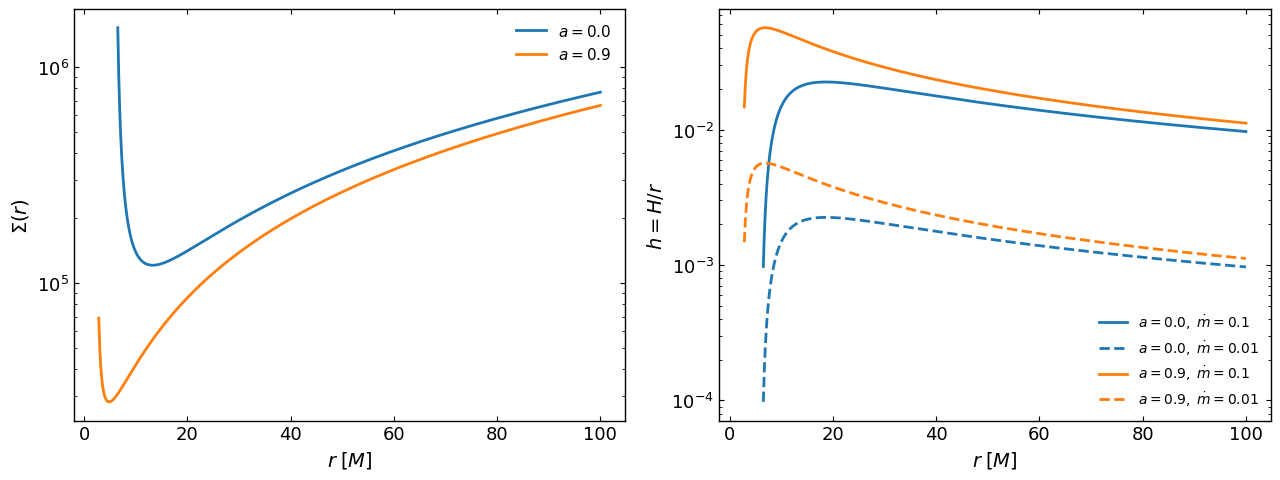

In [24]:
# ---- Disc profiles (cf. paper Fig. 5) ----
# Two spins × two accretion rates; same colour = same spin, dashed = second mdot

spin_cases = [0.0, 0.9]
mdot_cases = [0.1, 0.01]
spin_colors = {'0.0': 'C0', '0.9': 'C1'}
mdot_styles = {0.1: '-', 0.01: '--'}

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for a_spin in spin_cases:
    col = spin_colors[str(a_spin)]
    r_disk = np.linspace(isco_radius(a_spin) + 0.5, 100, 500)

    # Left panel: surface density Σ(r) — independent of mdot
    sigma_vals = np.array([disk_surface_density(r, a_spin) for r in r_disk])
    axes[0].semilogy(r_disk, sigma_vals, color=col, lw=2, ls='-',
                     label=rf'$a = {a_spin}$')

    # Right panel: aspect ratio h(r) — one curve per (spin, mdot)
    for mdot in mdot_cases:
        ls = mdot_styles[mdot]
        h_vals = np.array([disk_aspect_ratio(r, a_spin, mdot=mdot) for r in r_disk])
        axes[1].semilogy(r_disk, h_vals, color=col, lw=2, ls=ls,
                         label=rf'$a={a_spin},\;\dot{{m}}={mdot}$')

axes[0].set_xlabel(r'$r\;[M]$')
axes[0].set_ylabel(r'$\Sigma(r)$')
axes[0].legend(frameon=False)

axes[1].set_xlabel(r'$r\;[M]$')
axes[1].set_ylabel(r'$h = H/r$')
axes[1].legend(frameon=False, fontsize=10)

for ax in axes:
    ax.tick_params(direction='in', which='both', top=True, right=True)

fig.tight_layout()
plt.show()

---
## 7. Total Torque with Soft Cutoff

Modes with $m \gg 1/h$ are suppressed because the disk has finite thickness.

### Strategy

Computing $\hat{T}_m$ via the full Teukolsky solver for every $m$ up to
$m_{\rm cut} \sim 1/h$ (often $\gg 10$) is too expensive.  Instead:

1. **Calibrate** $\hat{T}_m$ at a few $m$ values (e.g. 2, 4, 6, 8, 10).
2. **Fit** a quadratic $\hat{T}_m \approx c_2 m^2 + c_1 m + c_0$.
3. **Sum** with a soft cutoff:

$$
T_{\rm total} = \sum_{m=2}^{m_{\rm max}}
  \underbrace{\frac{2}{1+e^{\xi_m}}}_{\text{sigmoid}}
  \;\underbrace{\frac{1}{1+4\xi_m^2}}_{\text{pressure}}
  \;\hat{T}_m^{\rm fit}
  \;\times\; 2\pi r_{\rm res}\,\Sigma(r_{\rm res})
$$

where $\xi_m = m\,h(r_p)$ and $m_{\rm max} = \lfloor 1/h \rfloor + m_{\rm extra}$.

In [25]:
def total_torque_with_cutoff(sign, r_perturber, a, sigma_func, h_func,
                              mdot, m_extra=50, m_calibration=None):
    """
    Total Lindblad torque (inner or outer) with soft cutoff.
    
    Parameters
    ----------
    sign          : +1 (inner) or -1 (outer)
    r_perturber   : perturber radius [M]
    a             : Kerr spin
    sigma_func    : sigma(r, a) -- disk surface density
    h_func        : h(r, a, mdot) -- disk aspect ratio
    mdot          : Eddington-normalised accretion rate
    m_extra       : modes beyond 1/h to include in the tail
    m_calibration : list of m at which to compute exact T_hat
    
    Returns
    -------
    T_total : summed physical torque  (float or NaN if calibration fails)
    """
    # ---- Cutoff scale ----
    h_val    = h_func(r_perturber, a, mdot)
    m_cutoff = 1.0 / h_val
    m_max    = int(m_cutoff) + m_extra

    # ---- Step 1: calibrate T_hat at a few m values ----
    if m_calibration is None:
        m_calibration = np.arange(2, 12, 2)   # [2, 4, 6, 8, 10]
    m_calibration = np.asarray(m_calibration)

    T_hat_vals, valid_m = [], []
    print(f"  Calibrating sign={sign:+d}: ", end='')
    for m in m_calibration:
        try:
            T = normalised_torque_strength(sign, m, r_perturber, a, l_max=10*(m-1))
            T_hat_vals.append(T); valid_m.append(m)
            print(f'm={m} OK  ', end='')
        except Exception:
            print(f'm={m} FAIL  ', end='')
    print()

    valid_m    = np.array(valid_m)
    T_hat_vals = np.array(T_hat_vals)
    mask = ~np.isnan(T_hat_vals)
    valid_m, T_hat_vals = valid_m[mask], T_hat_vals[mask]

    if len(valid_m) < 3:
        print(f'  WARNING: only {len(valid_m)} good calibration points -- returning NaN')
        return np.nan

    # ---- Step 2: quadratic fit T_hat(m) ----
    coeffs = np.polyfit(valid_m, T_hat_vals, deg=2)
    T_hat_fit = lambda m: coeffs[0]*m**2 + coeffs[1]*m + coeffs[2]

    # ---- Step 3: sum with soft cutoff ----
    T_total = 0.0
    for m in range(2, m_max):
        xi      = m * h_val
        sigmoid = 2.0 / (1.0 + np.exp(xi))       # decays for xi >> 1
        pressure = 1.0 / (1.0 + 4*xi**2)         # additional pressure suppression
        r_res   = find_resonance_radius(sign, m, r_perturber, a)
        T_total += sigmoid * pressure * T_hat_fit(m) \
                   * 2*np.pi * r_res * sigma_func(r_res, a)

    return T_total

### Surface density normalisation

The profile returned by `disk_surface_density` is dimensionless.
To express $\Sigma(r)$ in **geometric units** ($G = c = M_{\rm BH} = 1$)
we multiply by the conversion factor

$$
\Sigma_0 = \frac{G^2\,M_{\rm prim}}{c^4}
$$

which converts the physical surface density $[\mathrm{kg\,m^{-2}}]$ into
the geometric-unit measure $[1/M]$.  Set $M_{\rm prim}$ (mass of the
primary black hole in solar masses) in the cell below.

In [27]:
# =====================================================================
#  Primary black hole mass  —  SET THIS PARAMETER
# =====================================================================
Mprim = 5e5          # Black hole mass [M_sun]

# Physical constants (SI)
MSUN_SI = 1.9885e30           # Solar mass  [kg]
G_SI    = 6.67430e-11         # Gravitational constant  [m^3 kg^-1 s^-2]
C_SI    = 2.99792458e8        # Speed of light  [m s^-1]

# Surface density normalisation to geometric units (G = c = M_BH = 1)
# Sigma_geo = Sigma_phys [kg/m^2] × G^2 M / c^4
Sigma_0 = (Mprim * MSUN_SI) * G_SI**2 / C_SI**4

print(f"M_prim  = {Mprim:.1e} M_sun")
print(f"Sigma_0 = {Sigma_0:.6e}  (geometric-unit normalisation)")

M_prim  = 5.0e+05 M_sun
Sigma_0 = 5.483076e-19  (geometric-unit normalisation)


### Example: total torque at a single perturber radius

**Warning**: this cell is computationally expensive (several minutes).
Reduce `m_calibration` for a faster (less accurate) run.

In [28]:
a_val    = 0
r_p      = 20.0
mdot_val = 0.1

h_rp = h_wrapper(r_p, a_val, mdot_val)
print(f"h(r_p={r_p}) = {h_rp:.4f}   -->   m_cut ~ 1/h = {1/h_rp:.1f}\n")

T_inner = total_torque_with_cutoff(+1, r_p, a_val, sigma_wrapper, h_wrapper,
                                    mdot=mdot_val, m_extra=50,
                                    m_calibration=[2, 4, 6, 8, 10])
T_outer = total_torque_with_cutoff(-1, r_p, a_val, sigma_wrapper, h_wrapper,
                                    mdot=mdot_val, m_extra=50,
                                    m_calibration=[2, 4, 6, 8, 10])
T_total = T_inner + T_outer

print(f"\n{'='*50}")
print(f"Inner Lindblad torque  = {T_inner:.6e}")
print(f"Outer Lindblad torque  = {T_outer:.6e}")
print(f"Total torque           = {T_total:.6e}")
print(f"{'='*50}")

h(r_p=20.0) = 0.0224   -->   m_cut ~ 1/h = 44.6

  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  m=8 OK  m=10 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  m=8 OK  m=10 OK  

Inner Lindblad torque  = -2.625219e-07
Outer Lindblad torque  = 2.861927e-07
Total torque           = 2.367078e-08


---
## 8. Comparison with GW Torques (cf. [Duque et al. 2025](https://arxiv.org/abs/2510.02433), Fig. 1)

To assess whether Lindblad torques are observationally relevant, we compare
them with the gravitational-wave (GW) angular-momentum flux that drives the
EMRI inspiral.

For a test particle of mass $\mu$ on a circular equatorial orbit in Kerr, the
leading-order (quadrupole) GW angular-momentum flux is

$$
\dot{L}_z^{\rm GW} = -\frac{32}{5}\,\mu^2\,v^7,
\qquad v \equiv (M\,\Omega)^{1/3},
$$

where $\Omega = \Omega(r,a)$ is the orbital frequency.  Because both
$T_{\rm LR}$ and $\dot{L}_z^{\rm GW}$ scale as $\mu^2$ (the secondary mass
cancels in the ratio), the quantity

$$
\left|\frac{T_{\rm LR}}{\dot{L}_z^{\rm GW}}\right|
$$

is independent of $\mu$ and characterises the relative importance of the disk
torques.

> **Note:** The leading-order formula underestimates $|\dot{L}_z^{\rm GW}|$ close to
> the ISCO; for production results one should use numerically-accurate fluxes
> (e.g. from the [`few`](https://bhptoolkit.org/FastEMRIWaveforms/) package).

In [29]:
def gw_angular_momentum_torque(r, a):
    """
    Leading-order (quadrupole) GW angular-momentum loss rate
    for a circular equatorial prograde orbit in Kerr.

    Returns |dL_z/dt|_GW  per unit mu^2  (geometric units, M = 1).
    """
    Omega = orbital_frequency(r, a)
    v = Omega ** (1.0 / 3.0)
    return (32.0 / 5.0) * v ** 7

In [32]:
# =====================================================================
#  Compute T_LR / T_GW for two BH spin values  (cf. Fig. 1)
# =====================================================================
# WARNING: this cell is very expensive.  On a laptop each spin case
#          takes roughly  len(r_grid) × (calibration time per radius).
#          Reduce r_grid or m_calibration for a faster run.

spin_cases_fig1 = [0.0, 0.9]
mdot_fig1       = 0.1

# Store results per spin: {a: (r_array, T_inner, T_outer, T_total, T_gw)}
fig1_data = {}

for a_spin in spin_cases_fig1:
    r_isco = isco_radius(a_spin)
    # Radial grid: denser in the strong field to resolve the sign reversal
    r_candidates = [r_isco + 2.0, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50]
    r_grid = np.array([r for r in r_candidates if r > r_isco + 1.5])

    Ti_list, To_list, Tgw_list = [], [], []
    print(f"\n{'='*60}")
    print(f"  Spin a = {a_spin},  ISCO = {r_isco:.3f} M")
    print(f"  Radial grid: {r_grid}")
    print(f"{'='*60}")

    for rp in r_grid:
        print(f"\n--- r_p = {rp:.2f} M ---")
        Ti = total_torque_with_cutoff(+1, rp, a_spin,
                                       sigma_wrapper, h_wrapper,
                                       mdot=mdot_fig1, m_extra=30,
                                       m_calibration=[2, 4, 6])
        To = total_torque_with_cutoff(-1, rp, a_spin,
                                       sigma_wrapper, h_wrapper,
                                       mdot=mdot_fig1, m_extra=30,
                                       m_calibration=[2, 4, 6])
        Tgw = gw_angular_momentum_torque(rp, a_spin)
        Ti_list.append(Ti); To_list.append(To); Tgw_list.append(Tgw)

    fig1_data[a_spin] = {
        'r':       np.array(r_grid),
        'T_inner': np.array(Ti_list),
        'T_outer': np.array(To_list),
        'T_total': np.array(Ti_list) + np.array(To_list),
        'T_gw':    np.array(Tgw_list),
    }
    print(f"\nDone for a = {a_spin}.")

print("\n*** All spin cases complete. ***")


  Spin a = 0.0,  ISCO = 6.000 M
  Radial grid: [ 8.  8.  9. 10. 12. 14. 16. 18. 20. 25. 30. 40. 50.]

--- r_p = 8.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 8.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 9.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 10.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 12.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  

/var/folders/7l/48tv2_t54hz4dd6kdtp96bww0000gp/T/ipykernel_1504/449192021.py:27: RuntimeWarning: invalid value encountered in divide
  D_Up  = Del**(-s)*Up_ms / W
/var/folders/7l/48tv2_t54hz4dd6kdtp96bww0000gp/T/ipykernel_1504/449192021.py:28: RuntimeWarning: invalid value encountered in divide
  dD_Up = (Del**(-s)*dUp_ms - s*dDel*Del**(-s-1)*Up_ms) / W
/var/folders/7l/48tv2_t54hz4dd6kdtp96bww0000gp/T/ipykernel_1504/449192021.py:41: RuntimeWarning: invalid value encountered in divide
  return -np.mean(b_Up / a_Up)


m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 14.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 16.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 18.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 20.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 25.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 30.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 40.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  m=6 OK  

--- r_p = 50.00 M ---
  Calibrating sign=+1: m=2 OK  m=4 OK  m=6 OK  
  Calibrating sign=-1: m=2 OK  m=4 OK  

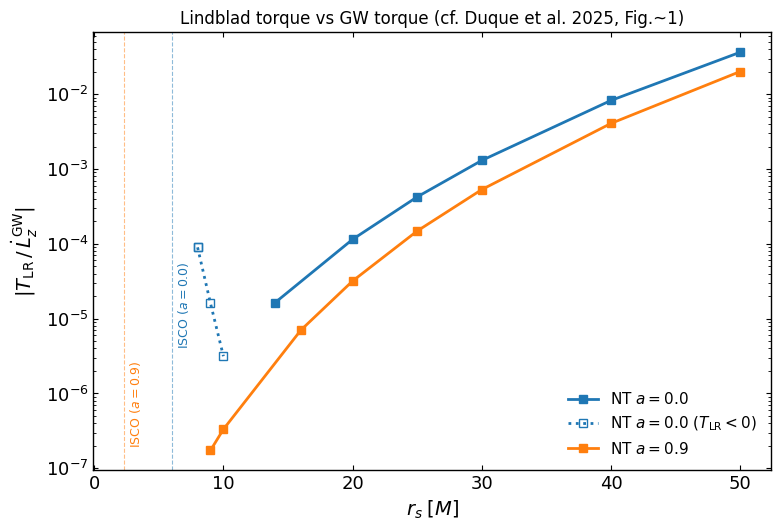

In [34]:
# =====================================================================
#  Plot  |T_LR / T_GW|  vs  r_s   (cf. Duque et al. 2025, Fig. 1)
# =====================================================================

plt.rcParams.update({
    'font.size': 13, 'axes.labelsize': 14,
    'legend.fontsize': 11, 'xtick.direction': 'in',
    'ytick.direction': 'in', 'xtick.top': True,
    'ytick.right': True, 'axes.linewidth': 1.0,
})

spin_colors_fig1 = {0.0: 'C0', 0.9: 'C1'}

fig, ax = plt.subplots(figsize=(8, 5.5))

for a_spin in spin_cases_fig1:
    d     = fig1_data[a_spin]
    r_arr = d['r']
    ratio = d['T_total'] / d['T_gw']   # signed ratio

    col = spin_colors_fig1[a_spin]
    r_isco = isco_radius(a_spin)

    # Positive T_LR  (OLR dominates → inward migration)
    pos = ratio >= 0
    neg = ratio <  0

    lbl_pos = rf'NT $a={a_spin}$'
    lbl_neg = rf'NT $a={a_spin}$ ($T_{{\rm LR}}<0$)'

    if np.any(pos):
        ax.semilogy(r_arr[pos], np.abs(ratio[pos]),
                    's-', color=col, lw=2, ms=6, label=lbl_pos)
    if np.any(neg):
        ax.semilogy(r_arr[neg], np.abs(ratio[neg]),
                    's:', color=col, lw=2, ms=6, mfc='none', label=lbl_neg)

    # Mark ISCO
    ax.axvline(r_isco, color=col, ls='--', lw=0.8, alpha=0.5)
    ax.text(r_isco + 0.3, ax.get_ylim()[0] * 2 if ax.get_ylim()[0] > 0 else 1e-3,
            rf'ISCO ($a={a_spin}$)', fontsize=9, color=col, rotation=90, va='bottom')

ax.set_xlabel(r'$r_s\;[M]$')
ax.set_ylabel(r'$|T_{\rm LR}\,/\,\dot{L}_z^{\rm GW}|$')
ax.legend(frameon=False, fontsize=11)
ax.set_title(r'Lindblad torque vs GW torque (cf. Duque et al. 2025, Fig.~1)',
             fontsize=12)
fig.tight_layout()
plt.show()